# Call Center - Sentiment Analysis Pipeline

This notebook demonstrates how to build a pipeline for sentiment analysis of call center conversations. The goal of this pipeline is to develop sentiment analysis for use within an external dashboard.

This tutorial will guide you through the use of [NVIDIA's RIVA](https://developer.nvidia.com/riva)  for automatic speech recognition and text classification. This tutorial uses NetApp cloud storage for data storage and a pre-trained RIVA model.

In [1]:
%load_ext autoreload
%autoreload 2

## Library Installations

In [2]:
!pip install pydub
!pip install jiwer
!pip install rouge
!pip install gdown
!pip install tqdm
!pip install matplotlib

distutils: /usr/local/lib/python3.8/dist-packages
sysconfig: /usr/lib/python3.8/site-packages
distutils: /usr/local/lib/python3.8/dist-packages
sysconfig: /usr/lib/python3.8/site-packages
distutils: /usr/local/include/python3.8/UNKNOWN
sysconfig: /usr/include/python3.8/UNKNOWN
distutils: /usr/local/bin
sysconfig: /usr/bin
distutils: /usr/local
sysconfig: /usr
user = False
home = None
root = None
prefix = None
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
distutils: /usr/local/lib/python3.8/dist-packages
sysconfig: /usr/lib/python3.8/site-packages
distutils: /usr/local/lib/python3.8/dist-packages
sysconfig: /usr/lib/python3.8/site-packages
distutils: /usr/local/include/python3.8/UNKNOWN
sysconfig: /usr/include/python3.8/UNKNOWN
distutils: /usr/local/bin
sysconfig: /usr/bin
distutils: /usr/local
sysconfig: /usr
user = False
home = None
root = None
prefix = None
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrad

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
distutils: /usr/local/lib/python3.8/dist-packages
sysconfig: /usr/lib/python3.8/site-packages
distutils: /usr/local/lib/python3.8/dist-packages
sysconfig: /usr/lib/python3.8/site-packages
distutils: /usr/local/include/python3.8/UNKNOWN
sysconfig: /usr/include/python3.8/UNKNOWN
distutils: /usr/local/bin
sysconfig: /usr/bin
distutils: /usr/local
sysconfig: /usr
user = False
home = None
root = None
prefix = None
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


## Importing Libraries

In [3]:
## General ##
import io
import os 
import grpc
import librosa
import librosa.display
import IPython.display as ipd
from pathlib import Path
from tqdm.notebook import tqdm


## Data Science ##
import random
import numpy as np
import matplotlib.pyplot as plt


## RIVA ##
# Automatic Speech Recognition (ASR) #
import riva_api.audio_pb2 as ra
import riva_api.riva_asr_pb2 as rasr
import riva_api.riva_asr_pb2_grpc as rasr_srv

# Sentiment Analysis #
import riva_api.riva_nlp_pb2 as rnlp
import riva_api.riva_nlp_pb2_grpc as rnlp_srv


# Utilities #
from utils_RIVA import (
    # Speech-to-Text #
    download_data,
    unzip_data,
    read_audio,
    audio2text,
    word_error_rate,
    rouge_error,
    read_files,
    natural_keys,
    mp3_2_wav,
    batch_metrics,
    # Sentiment Analysis #
    run_text_classify,
    validation_sentiment_analysis,
)

### Channels

These are the channels on which RIVA is hosting models.

- speech: `51051`
- voice: `61051`

These channels **must** be aligned with `riva_speech_api_port` and `riva_vision_api_port` within `config.sh`

In [4]:
speech_channel = "localhost:51051"
voice_channel = "localhost:61051"

# Speech-To-Text

Automatic Speech Recognition (ASR) takes as input an audio stream or audio buffer and returns one or more text transcripts, along with additional optional metadata. ASR represents a full speech recognition pipeline that is GPU accelerated with optimized performance and accuracy. ASR supports synchronous and streaming recognition modes.

For more information on NVIDIA RIVA's Automatic Speech Recognition, visit [here](https://docs.nvidia.com/deeplearning/riva/user-guide/docs/service-asr.html).

## Constants

Use these constants to affect different aspects of this pipeline:
- `DATA_DIR`: base folder where data is stored
- `DATASET_NAME`: name of the call center dataset
- `COMPANY_DATE`: folder name identifying the particular call center conversation

#### NOTE: MAKE SURE THESE CONSTANTS ALIGN WITH `Call Center - Model Training and Fine-Tuning.ipynb`

In [5]:
DATA_DIR = "data"
DATASET_NAME = "ReleasedDataset_mp3"
COMPANY_DATE = "Aetna Inc_20171031"

## Data Acquisition

In the cell below, download the call center data from your database into the local storage system. The local location is specified by `DATA_DIR`, and the `DATASET_NAME` determines the call center dataset.

In [6]:
FIRST_TIME_DOWNLOAD = False

if FIRST_TIME_DOWNLOAD:
    download_data(DATA_DIR)
    unzip_data(DATA_DIR)

## Loading Files

Once the call center audio files are loaded into the local storage, they can be processed for use within NVIDIA RIVA.

In [7]:
paths = read_files(
    path = os.path.join(DATA_DIR, DATASET_NAME, COMPANY_DATE, "Audio"),
    extension = "mp3",
)

## Creating Wav Files

In general, one should avoid working with MP3 files because the use of lossy codecs can reduce quality and performance. Lossless audio formats such as WAV are preferred.

These call center audio files were originally exported to MP3s, so they must be reformatted.

In [8]:
%%time 
mp3_2_wav(
    wav_path = os.path.join(DATA_DIR, DATASET_NAME, COMPANY_DATE, "Audio"),
    mp3_paths = paths,
)

CPU times: user 789 ms, sys: 1.24 s, total: 2.03 s
Wall time: 18.9 s


In [9]:
paths = read_files(
    path = os.path.join(DATA_DIR, DATASET_NAME, COMPANY_DATE, "Audio" , "wav"),
    extension = "wav",
)

The individual conversation sentences can be visualized and heard within the sentiment analysis dashboard.

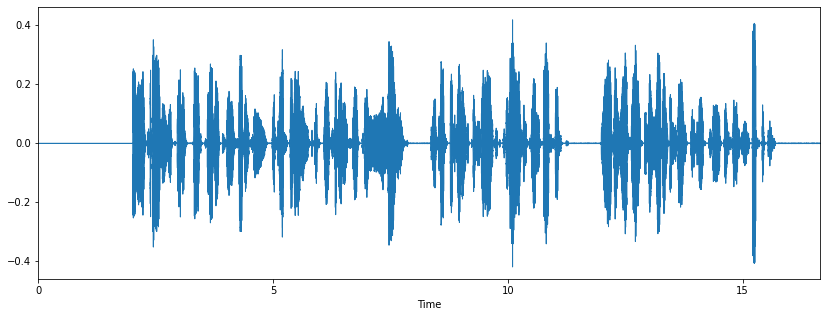

In [10]:
idx = 1

x, sr = librosa.load(paths[idx])
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)
plt.show()

ipd.Audio(paths[idx])

# [NetApp DataOps Toolkit](https://github.com/NetApp/netapp-dataops-toolkit)

The massive volume of calls that a call center must process on a daily basis means that a database can be quickly overwhelmed by audio files. Efficiently managing the processing and transfer of these audio files is an integral part of the sentiment analysis pipeline.

The data processing steps can be facilitated through the use of the **NetApp DataOps Toolkit**. This toolkit is a Python library that makes it simple for developers, data scientists, DevOps engineers, and data engineers to perform various data management tasks, such as provisioning a new data volume, near-instantaneously cloning a data volume, and near-instantaneously snapshotting a data volume for traceability/baselining. 

Installation and usage of the **NetApp DataOps Toolkit** for Traditional Environments requires that Python 3.6 or above be installed on the local host. Additionally, the toolkit requires that pip for Python3 be installed.

For more information on the **NetApp DataOps Toolkit**, click [here](https://github.com/NetApp/netapp-dataops-toolkit).

To install the **NetApp DataOps Toolkit** for Traditional Environments, run the following command.

```
python3 -m pip install netapp-dataops-traditional
```

A config file must be created before the **NetApp DataOps Toolkit** for Traditional Environments can be used to perform data management operations. To create a config file, run the following command. This command will create a config file named 'config.json' in '~/.netapp_dataops/'.

```
netapp_dataops_cli.py config
```

In [11]:
CREATE_WAV_ALL_MP3S = True

In [12]:
if CREATE_WAV_ALL_MP3S:
    company_dates = sorted(os.listdir(os.path.join(DATA_DIR, DATASET_NAME)))
    
    for company_date in tqdm(company_dates):
        if not os.path.exists(os.path.join(DATA_DIR, DATASET_NAME, company_date, "Audio", "wav")):
            mp3_paths = read_files(
                path = os.path.join(DATA_DIR, DATASET_NAME, company_date, "Audio"),
                extension = "mp3",
            )
            mp3_2_wav(
                wav_path = os.path.join(DATA_DIR, DATASET_NAME, company_date, "Audio"),
                mp3_paths = mp3_paths,
            )

  0%|          | 0/575 [00:00<?, ?it/s]

## Initializing RIVA

To connect to the RIVA speech api server, we create a RIVA client that we can connect to the appropriate servers via the specified ports through grpc.

In [13]:
channel = grpc.insecure_channel(speech_channel)
asr_client = rasr_srv.RivaSpeechRecognitionStub(channel)

### Automatic Speech Recognition

The WAV files are passed through the RIVA ASR API to obtain the speech-to-text transcription. 

In [14]:
%%time 
contents, sample_rate = read_audio(paths)

CPU times: user 145 ms, sys: 226 ms, total: 371 ms
Wall time: 672 ms


In [15]:
%%time 
transcript_predicted = audio2text(contents, sample_rate, asr_client)

CPU times: user 128 ms, sys: 77.4 ms, total: 206 ms
Wall time: 22 s


In [16]:
transcript_predicted

"Hank you ark and good morning everyone. \nArlier today we reported 3rd quarter. Adjusted earnings of million. And adjusted earnings per share of. Earoveryear growth of and. Respectively. \nUr 3rd quarter results reflect strong core business fundamentals driven by disciplined pricing moderate medical cost trends and continued capital deployment. \nGive with some comments on overall performance. \nUr medical membership with. Million is in line with our expectations for the period. \nDjusted revenue was billion. A yearoveryear decrease driven by a planned reduction in commercial and shared membership. Despansion of the health ansure feet and no edicaid contract loffers. \nHese dynamics were partially offset by higher premium yields in our commercial engovernment businesses and membership growth in our edicare products. \nRom an operating perspective our businesses are performing well. \nUr adjusted pretax margin was. A very strong result and at the high end of our target range. \nUr 3rd 

### Actual Transcript

The actual transcripts are read into memory to compare to the RIVA predicted transcripts.

In [17]:
paths = read_files(
    os.path.join(DATA_DIR, DATASET_NAME, COMPANY_DATE),
    extension = "txt"
)

In [18]:
transcript_actual = Path(paths[0]).read_text()

In [19]:
transcript_actual 

"Thank you, Mark, and good morning, everyone\nEarlier today, we reported third quarter 2017 adjusted earnings of $814 million and adjusted earnings per share of $2.45, year-over-year growth of 11% and 18% respectively\nOur third quarter results reflect strong core business fundamentals driven by disciplined pricing, moderate medical cost trend and continued capital deployment\nI'll begin with some comments on overall performance\nOur medical membership of 22.2 million is in line with our expectations for the period\nAdjusted revenue was $14.9 billion, a year-over-year decrease driven by a planned reduction in Commercial ACA insured membership, the 2017 suspension of the health insurer fee and known Medicaid contract losses\nThese dynamics were partially offset by higher premium yields in our Commercial and Government businesses and membership growth in our Medicare products\nFrom an operating perspective, our businesses are performing well\nOur adjusted pre-tax margin was 9.2%, a very 

## Performance Metrics

Word Error Rate (WER) measures the edit distance in words. Lower WER scores are preferred.

```
WER = (Insertions + Deletions + Substitutions)/N_Words
```


In [20]:
wer = word_error_rate(transcript_predicted, transcript_actual)
print("Word Error Rate:", round(wer, 2))

Word Error Rate: 0.48


Recall-Oriented Understudy for Gisting Evaluation (ROUGE) measures overlap as n-grams. All ROUGE scores reported are for bigram overlap (ROUGE-2). Higher ROUGE scores are preferred.

In [21]:
rouge = rouge_error(transcript_predicted, transcript_actual)
rouge = {key : round(rouge[0]["rouge-2"][key], 2) for key in rouge[0]["rouge-2"]}
rouge

{'r': 0.44, 'p': 0.48, 'f': 0.46}

#### Side by side comparison of predicted vs actual transcripts

In [22]:
print("[PREDICTED]:",transcript_predicted.split("\n")[2])
print("[ACTUAL]:   ",transcript_actual.split("\n")[2])

[PREDICTED]: Ur 3rd quarter results reflect strong core business fundamentals driven by disciplined pricing moderate medical cost trends and continued capital deployment. 
[ACTUAL]:    Our third quarter results reflect strong core business fundamentals driven by disciplined pricing, moderate medical cost trend and continued capital deployment


## Performance Metrics across a batch of calls

We measure the average WER and ROUGE for an specified number (`batch_size`) of companies.

In [23]:
_, _ = batch_metrics(
    data_dir = DATA_DIR,
    dataset_name = DATASET_NAME,
    asr_client = asr_client,
    batch_size = 20,
)

[COMPANY_DATE]  Hewlett Packard Enterprise_20170905
data/ReleasedDataset_mp3/Hewlett Packard Enterprise_20170905/Audio/wav
[WER]  0.32
[ROUGE]  {'r': 0.58, 'p': 0.6, 'f': 0.59}
[COMPANY_DATE]  The Mosaic Company_20170801
data/ReleasedDataset_mp3/The Mosaic Company_20170801/Audio/wav
[WER]  0.46
[ROUGE]  {'r': 0.43, 'p': 0.46, 'f': 0.44}
[COMPANY_DATE]  Hologic_20171108
data/ReleasedDataset_mp3/Hologic_20171108/Audio/wav
[WER]  0.52
[ROUGE]  {'r': 0.38, 'p': 0.4, 'f': 0.39}
[COMPANY_DATE]  F5 Networks_20170426
data/ReleasedDataset_mp3/F5 Networks_20170426/Audio/wav
[WER]  0.51
[ROUGE]  {'r': 0.37, 'p': 0.43, 'f': 0.4}
[COMPANY_DATE]  American Tower Corp A_20171031
data/ReleasedDataset_mp3/American Tower Corp A_20171031/Audio/wav
[WER]  0.46
[ROUGE]  {'r': 0.43, 'p': 0.52, 'f': 0.47}
[COMPANY_DATE]  The Clorox Company_20171101
data/ReleasedDataset_mp3/The Clorox Company_20171101/Audio/wav
[WER]  0.53
[ROUGE]  {'r': 0.37, 'p': 0.38, 'f': 0.37}
[COMPANY_DATE]  Kohl's Corp._20170223
data/Re

# Sentiment Analysis

Text Classification is the task of classifying any given input text (or sequence of tokens) into a predefined set of classes. You can use this generic text classification task for various domain specific use cases such as sentiment classification, topic classification, intent classification, domain classification, etc.

For more information on NVIDIA RIVA's Text Classification, visit [here](https://docs.nvidia.com/deeplearning/riva/user-guide/docs/service-nlp.html).

In [24]:
sentiment_results = run_text_classify(
    server = speech_channel,
    model = "riva_text_classification_default",
    query = transcript_predicted.split("\n"),
)
sentiments = [x[1] for x in sentiment_results]

Client app to test text classification on Riva
Using model: riva_text_classification_default


### Sentiment Analysis Dashboard

Finally, the sentiment analysis can be displayed via a dashboard UI. Users will be able to track the sentiments in a conversation in realtime and investigation historic sentiments at various levels of granularity.

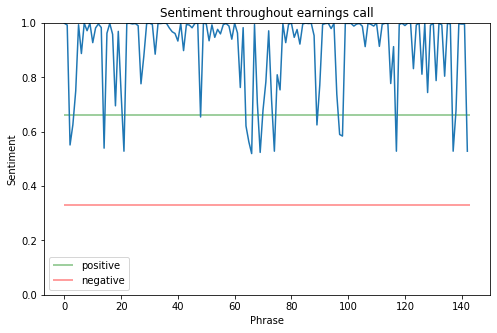

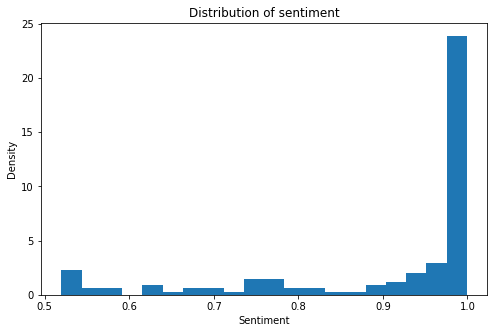

In [25]:
validation_sentiment_analysis(sentiments)